##### <font color=#A0A0A0>
### ════════════════════════════════════════════════════════
####     📊 **MODEL TRAINING**
### ═══════════════════════════════════════════════════════ </font>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [3]:
#Data loading
data = pd.read_csv('../data/apartments_bogota.csv')
data.head()

,longitude,latitude,stratum,bathrooms,constructed_area,house_age,bedrooms,parking,administration,floor,rent_price,Localidad
0,-74.048398,4.700991,5.0,2.0,97.0,12.0,2.0,2.0,0.0,0.0,4500000.0,USAQUEN
1,-74.055693,4.687506,6.0,1.0,42.0,12.0,1.0,1.0,0.0,5.0,2800000.0,USAQUEN
2,-74.052512,4.675927,6.0,4.0,116.0,23.0,4.0,2.0,0.0,7.0,5500000.0,CHAPINERO
3,-74.049210,4.672860,5.0,3.0,138.0,23.0,3.0,2.0,0.0,4.0,8000000.0,CHAPINERO
4,-74.050727,4.700429,5.0,2.0,78.0,23.0,3.0,1.0,0.0,3.0,4000000.0,USAQUEN


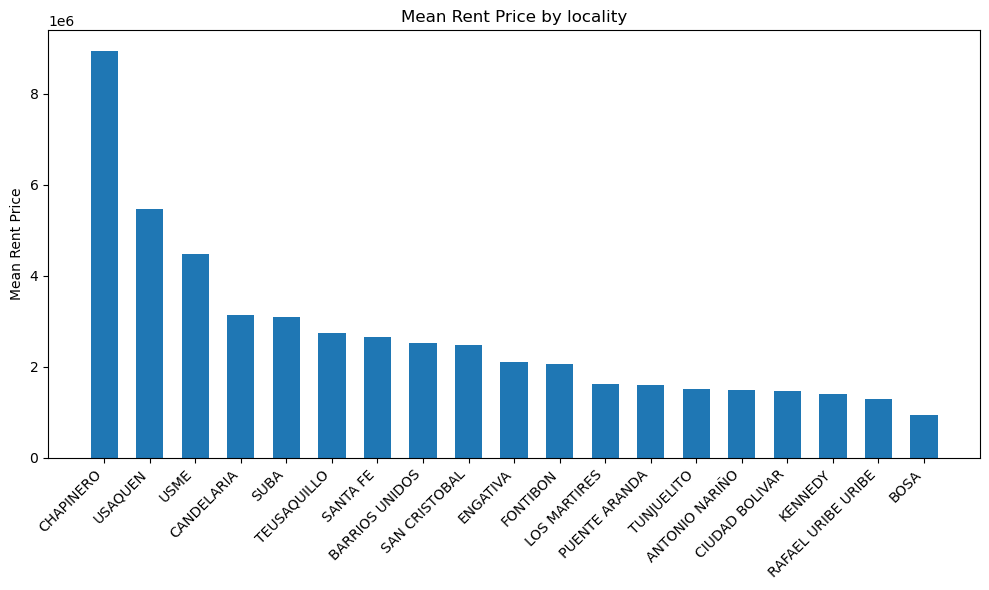

In [5]:
mean_price_localidad = data.groupby('Localidad')['rent_price'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(
    mean_price_localidad.index,
    mean_price_localidad.values,
    width=0.6  
)
plt.ylabel('Mean Rent Price')
plt.title('Mean Rent Price by locality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
X = data.drop(columns=['rent_price'])
y = data['rent_price']

In [6]:
continuos_features = ['longitude', 'latitude', 'constructed_area', 'house_age', 'administration', 'floor','stratum', 'bathrooms', 'bedrooms', 'parking']
preprocessor = ColumnTransformer(transformers=[
    ('cont', StandardScaler(), continuos_features)
])

In [13]:
param_grid_xgb = {
    'regressor__n_estimators': [200, 300],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__max_depth':[5, 8],
    'regressor__subsample':[0.8,1],
    'regressor__colsample_bytree': [0.8,1],
    'regressor__reg_lambda': [1,2]
}

grid_search_xgb = GridSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators =100, random_state=42, verbosity=0))
    ]),
    param_grid_xgb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1)

grid_search_xgb.fit(X, y)
best_index = grid_search_xgb.best_index_
std_rmse = grid_search_xgb.cv_results_['std_test_score'][best_index]

print(f"Best RMSE: {-grid_search_xgb.best_score_:.2f}")
print("Best params:", grid_search_xgb.best_params_)
print("Best score (std_RMSE):", std_rmse)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE: 1654633.39
Best params: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 8, 'regressor__n_estimators': 200, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}
Best score (std_RMSE): 103761.8315640966


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = grid_search_xgb.best_estimator_

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE test: {rmse:.2f}')
print(f'MAE test: {mae:.2f}')
print(f'R2 test: {r2:.2f}')

RMSE test: 1606203.72
MAE test: 833413.61
R2 test: 0.89


In [17]:
import joblib
import os

joblib.dump(best_model, '../model/best_xgb_pipeline.pkl')

['../model/best_xgb_pipeline.pkl']